# Tuning RF

In [97]:
import utils as utils
import holidays
import re
from collections import Counter
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report,plot_confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import boxcox, boxcox_normmax, probplot
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")

In [98]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [99]:
def learning_rate_010_decay_power_099(current_iter): #2
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter): #1
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter): #3
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

# LEITURA

In [100]:
incidentes = import_data('../input/train_data_w_IC_EM.csv')
teste = import_data('../input/test_data_w_IC_EM.csv')

Memory usage of dataframe is 0.80 MB
Memory usage after optimization is: 0.13 MB
Decreased by 83.9%
Memory usage of dataframe is 0.18 MB
Memory usage after optimization is: 0.03 MB
Decreased by 81.2%


In [101]:
incidentes.head()

,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,National,...,IC,EM,day_of_month,week_day,month,hour,day_of_year,season,is_holiday,is_weekend
0,0,0,0,12.0,1013.0,70.0,1.0,0,0,0,...,0,0,15,0,3,23,74,0,0,1
1,0,385,0,12.0,1007.0,91.0,1.0,0,0,1,...,0,0,25,5,12,18,359,3,1,1
2,0,69,2,14.0,1025.0,64.0,0.0,0,1,0,...,0,0,12,4,3,15,71,0,0,1
3,2,2297,2,15.0,1028.0,75.0,1.0,0,4,10,...,0,0,29,2,9,9,272,3,0,1
4,0,0,2,27.0,1020.0,52.0,1.0,0,3,5,...,0,0,13,6,6,11,164,1,0,1


In [102]:
#divisão do target
x = incidentes.drop(['incidents'], axis=1)
y = incidentes['incidents']

### Base Model

In [103]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [104]:
rf_model = RandomForestClassifier(n_estimators=100, max_features="sqrt", random_state=42)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.90      0.91      0.90       189
           2       0.88      0.84      0.86       144
           3       0.92      0.91      0.91       265
           4       0.89      0.94      0.92       135

    accuracy                           0.94      1250
   macro avg       0.92      0.92      0.92      1250
weighted avg       0.94      0.94      0.94      1250

0.9376


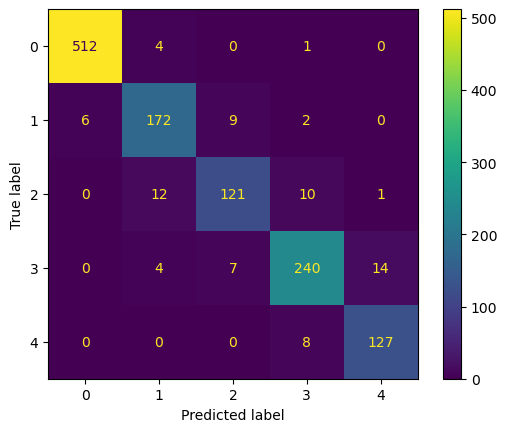

In [105]:
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print(classification_report(y_test,rf_pred))
plot_confusion_matrix(rf_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, rf_pred))

# Random Forest Default Classifier

In [106]:
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [107]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Aplicar randomS ao default model

In [109]:
rf_model = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid,
                              n_iter = 100, scoring='accuracy', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   6.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   7.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   7.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   6.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  13.8s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  14.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

In [110]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [111]:
best_random = rf_random.best_estimator_
print(best_random)

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=5,
                       n_estimators=1200)


# Avaliar ambos os modelos

In [112]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    accuracy = accuracy_score(test_labels,predictions)
    print('Model Performance')
    print('Accuracy = {:0.4f}%.'.format(accuracy))
    
    return accuracy

In [113]:
base_model = RandomForestClassifier(n_estimators=100, max_features="sqrt", random_state=42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Accuracy = 0.9376%.


In [114]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Accuracy = 0.9368%.


In [115]:
print('Improvement of {:0.4f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of -0.0853%.


A combinação aleatória de hiperparâmetros escolhida pelo Random Search pode não ser a melhor possível para o conjunto de dados. É possível que existam outras combinações de hiperparâmetros que resultem em um modelo com uma accuracy maior. Vamos ver com grid search.

In [123]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50, 70, 80, 100, 110],
    'min_samples_leaf': [1, 2, 4, 6],
    'min_samples_split': [2, 4, 8, 10],
    'n_estimators': [100, 300, 600, 1000]
}

base_model =  RandomForestClassifier(random_state=42, max_features='sqrt')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = base_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [124]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.7s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.5s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.5s
[CV] END max_depth=50, min_s

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [50, 70, 80, 100, 110],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 4, 8, 10],
                         'n_estimators': [100, 300, 600, 1000]},
             return_train_score=True, verbose=2)

In [125]:
grid_search.best_params_

{'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [126]:
best_gs = grid_search.best_estimator_
gs_accuracy = evaluate(best_gs, X_test, y_test)

Model Performance
Accuracy = 0.9336%.


In [127]:
print('Improvement of {:0.4f}%.'.format( 100 * (gs_accuracy - base_accuracy) / base_accuracy))

Improvement of -0.4266%.


Após várias tentativas, não conseguimos obter melhoramento.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.90      0.91      0.90       189
           2       0.88      0.84      0.86       144
           3       0.92      0.91      0.91       265
           4       0.89      0.94      0.92       135

    accuracy                           0.94      1250
   macro avg       0.92      0.92      0.92      1250
weighted avg       0.94      0.94      0.94      1250

0.9376


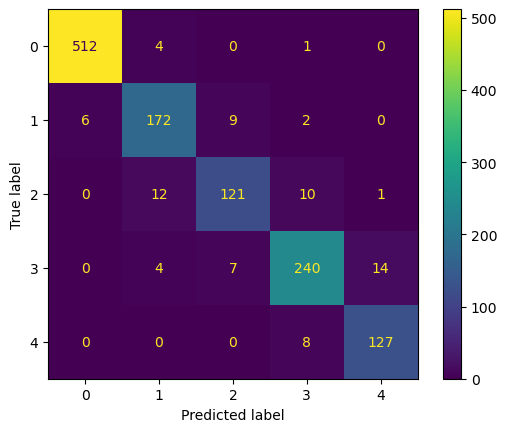

In [130]:
rf_model = RandomForestClassifier(n_estimators=100, max_features="sqrt", random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print(classification_report(y_test,rf_pred))
plot_confusion_matrix(rf_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, rf_pred))